In [11]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import hydrocyclone
%load_ext mcmc
%mcmc notebook

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [12]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [13]:
scale = 1000
stim_current = 1.0

kernel_variance_mult = 1e-2
kernel_ls = 0.3
conductivity_variance_mult = 1. # 1e-3 is good
conductivity_ls = 0.3
run_time = 11

likelihood_variance = 1e-6 # variance for the observation model - based on the value from RA paper

In [14]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [15]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [16]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [17]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [18]:
pattern = hydrocyclone.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [19]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

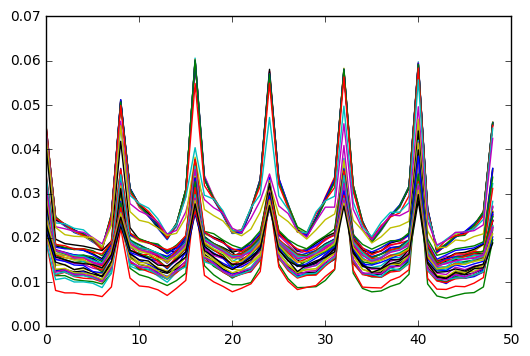

In [20]:
plt.plot(raw_data[:,1:].T);

In [21]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [22]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [23]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [24]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

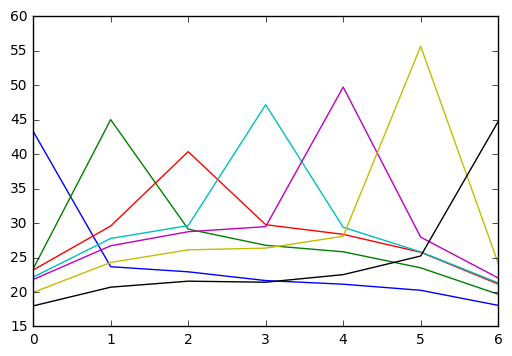

In [25]:
plt.plot(data_dict[run_time]);

# Set Up

In [26]:
from bayesian_pdes.problems import eit

In [27]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [28]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [53]:
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [A, B], [A_bar, B_bar],
    kernel,
    symbols,
    parallel=True
)

In [30]:
#op_system_factory = eit.EITFactory(kernel, symbols[0], symbols[1], symbols[2])

## Define the collocation grid

In [54]:
n_in_shell = 8
n_bdy = 64
n_sensor = 8
grid = hydrocyclone.grids.construct_circular(n_in_shell, n_bdy, n_sensor)

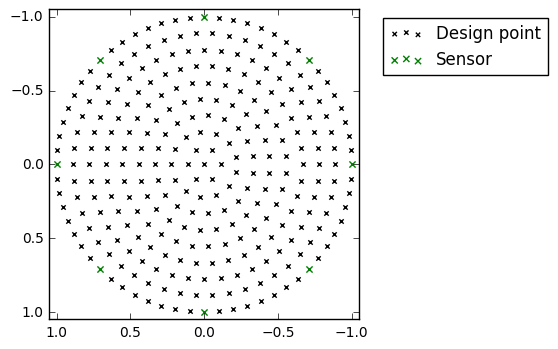

In [55]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='x', color='green', label='Sensor')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Define the Potential

In [56]:
# todo: choose this in a more principled way
length_scale = 0.3
fun_args = np.array([kernel_ls, kernel_variance_mult])

In [57]:
def construct_posterior(theta, debug=False):
    design_int = grid.interior_plus_boundary
    a_int, a_bdy, a_x, a_y = theta_to_a(theta,
                                        design_int.shape[0], 
                                        grid.sensors.shape[0]
                                       )
    
    augmented_int = np.column_stack([design_int, a_int, a_x, a_y])
    augmented_bdy = np.column_stack([grid.sensors, a_bdy, np.nan*np.zeros((a_bdy.shape[0], 2))])
    obs = [
        (augmented_int, None),
        (augmented_bdy, None)
    ]
    posterior = bpdes.collocate(
        op_system.operators,
        op_system.operators_bar,
        obs,
        op_system,
        fun_args,
        inverter='np'
    )
    return posterior

In [58]:
def phi(theta, debug=False):
    # first solve forward
    design_int = grid.interior_plus_boundary
    posterior = construct_posterior(theta, debug=debug)
    # now determine voltage at the sensor locations
    # we have seven observations so take one for each sensor other than sensor 1, the reference sensor
    augmented_locations = np.column_stack([grid.sensors, np.nan*np.zeros((8,3))])
    mu_mult, Sigma = posterior.no_obs_posterior(augmented_locations)
    
    # now need to iterate the stim patterns and compute the residual
    data = data_dict[run_time] if not use_dummy_data else dummy_data
    rhs_int = np.zeros((len(design_int), 1))
    
    Sigma_obs = np.dot(meas_pattern, np.dot(Sigma, meas_pattern.T))
    likelihood_cov = Sigma_obs + likelihood_variance*np.eye(Sigma_obs.shape[0])
    #likelihood_cov = likelihood_variance*np.eye(Sigma_obs.shape[0])
    likelihood_dist = stats.multivariate_normal(np.zeros(Sigma_obs.shape[0]), likelihood_cov)
    
    if debug:
        print("Sigma diag: {}\tCondition:{} \t Augmented Condition: {}".format(np.diag(Sigma), np.linalg.cond(Sigma), np.linalg.cond(likelihood_cov)))
    
    likelihood = 0
    for voltage, current in zip(data, stim_pattern):
        rhs_bdy = current[:,None]
        rhs = np.row_stack([rhs_int, rhs_bdy])
        
        model_voltage = np.dot(meas_pattern, np.dot(mu_mult, rhs))
        
        residual = voltage.ravel() - model_voltage.ravel()
        this_likelihood = likelihood_dist.logpdf(residual)
        if debug:
            print("Model|True\n {}".format(np.c_[model_voltage, voltage]))
            print("Likelihood: {}   |   Residual: {}".format(this_likelihood, np.abs(residual).sum()))
        likelihood += this_likelihood
    return -likelihood

In [59]:
def phi(theta, debug=False):
    data = data_dict[run_time] if not use_dummy_data else dummy_data
    return hydrocyclone.pcn_kernel.phi(grid, op_system, theta, likelihood_variance, pattern, data, fun_args, proposal_dot_mat, debug)

In [60]:
data_dict[run_time]

array([[ 43.32  ,  23.37  ,  23.19  ,  22.16  ,  21.81  ,  19.94  ,
         17.9811],
       [ 23.67  ,  45.02  ,  29.58  ,  27.77  ,  26.71  ,  24.29  ,
         20.7011],
       [ 22.93  ,  29.13  ,  40.37  ,  29.64  ,  28.75  ,  26.12  ,
         21.5711],
       [ 21.66  ,  26.78  ,  29.77  ,  47.19  ,  29.49  ,  26.37  ,
         21.4211],
       [ 21.13  ,  25.84  ,  28.37  ,  29.4   ,  49.75  ,  28.09  ,
         22.5211],
       [ 20.25  ,  23.51  ,  25.77  ,  25.82  ,  27.96  ,  55.68  ,
         25.2211],
       [ 18.06  ,  19.67  ,  21.16  ,  21.33  ,  22.04  ,  24.17  ,  44.75  ]])

## Set up Proposal Matrix

In [61]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [62]:
proposal_design = hydrocyclone.grids.construct_shell(np.linspace(0,1,8))

In [63]:
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [grid.all, grid.interior_plus_boundary, grid.interior_plus_boundary],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646664006.6509323

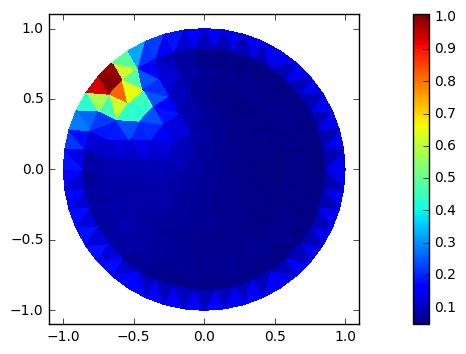

In [64]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [65]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)


In [66]:
import scipy.optimize
def phi_const(k):
    return phi(k*np.ones(proposal_cov.shape[0]))
best_const = scipy.optimize.minimize_scalar(phi_const)

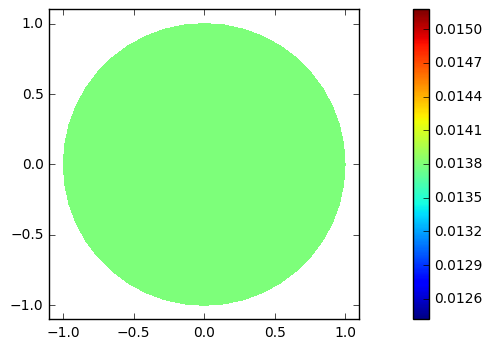

In [67]:
proposal = mcmc.pcn.proposal(0.005, proposal_cov)
#kappa_0 = np.random.multivariate_normal(np.zeros(proposal_cov.shape[0]), proposal_cov)
#kappa_0 = proposals[-1,:]
#kappa_0 = dummy_true_field[:len(full_design)]
kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(kappa_0))

In [68]:
print phi(kappa_0, False)
print phi(true_field, False)

8113304.93927
790631442.623


In [69]:
proposals, acceptances = mcmc.pCN(10000, proposal, phi, kappa_0)

Iter 1000: Accept (37% 37%) T/Iter 0.2034s Remaining 13m33s


KeyboardInterrupt: 

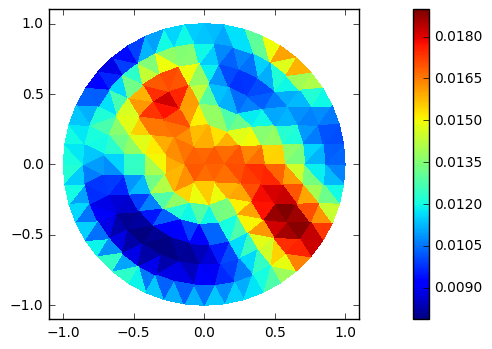

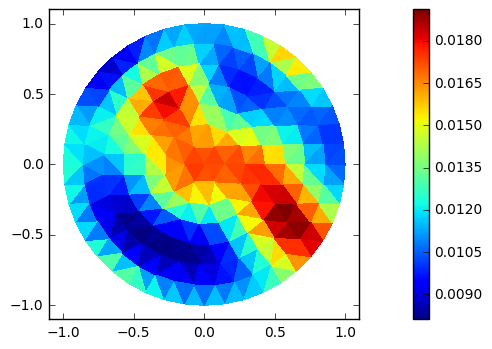

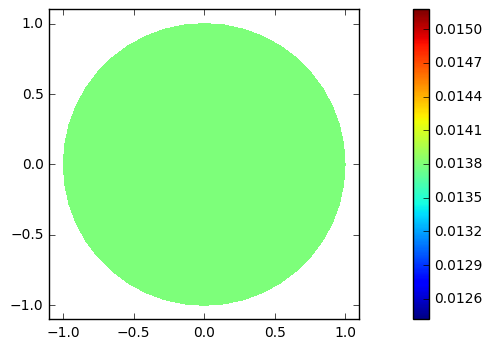

In [50]:
thin = 1
burn = int(proposals.shape[0]) / 2


recovered_field = proposals[burn::thin, :len(grid.all)].mean(axis=0)
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(recovered_field))
#plt.savefig('results/t={}_field.pdf'.format(run_time))
plt.figure()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(proposals[-1, :len(grid.all)]))
plt.figure()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(kappa_0[:len(grid.all)]))

In [51]:
print phi(recovered_field)
print phi(kappa_0)

73239.7253175
8113304.93927


In [52]:
a_int, a_bdy, a_x, a_y = theta_to_a(proposals[-1,:], len(modified_design_int), len(modified_design_bdy))
plot_circle(modified_design_int[:,0], modified_design_int[:,1], a_int)
plt.figure()
plot_circle(modified_design_int[:,0], modified_design_int[:,1],a_x)
plt.figure()
plot_circle(modified_design_int[:,0], modified_design_int[:,1], a_y)

NameError: name 'theta_to_a' is not defined

# Diagnostics

In [ ]:
field_to_test = recovered_field

In [ ]:
phi(field_to_test, True)

In [ ]:
p = construct_posterior(field_to_test)
mu_mult, cov = p.no_obs_posterior(np.column_stack([full_design, np.empty((full_design.shape[0],3))]))

In [ ]:
for i in xrange(stim_pattern.shape[0]):
    mu = mu_mult.dot(np.row_stack([
                np.zeros((len(modified_design_int), 1)),
                stim_pattern[i][:,None]
                ]
                             ))
    plt.figure()
    plot_circle(full_design[:,0], full_design[:,1], mu)

In [ ]:
np.save('results/t={}_samples.npy'.format(run_time), recovered_field)

In [ ]:
for i in np.random.choice(proposals.shape[1], 10):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(proposals[burn::thin,i])
    plt.subplot(122)
    plt.hist(proposals[burn::thin,i])

In [ ]:
phi(proposals[-1,:], True)

In [ ]:
phi(kappa_0, True)